- In this notebook, we do vesicle detection on microscopy images
- Then construct the data set for modeling

In [ ]:
# Add the src directory to sys.path
import sys
import os
sys.path.append(os.path.abspath('../src'))

In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from utils import *
from batch_run import run_batch_files_templates
import argparse
import pandas as pd
import time
import shutil
import re
import seaborn as sns

In [2]:
template1 = np.load('../Templates/template_656, 640, 71, 71.npy')
template2 = np.load('../Templates/Project_Whole Plate1_1024x1024_200Hz_1%Laser_800gain_B_5_R1.tif_enhance_482_20_56_56.npy')
template3 = np.load('../Templates/1024x1024 - 4 point_no-z-stack - split 5 rows rows only_TileScan 1_C_11_R2.npy')

In [3]:
templates = [template1, template2, template3]

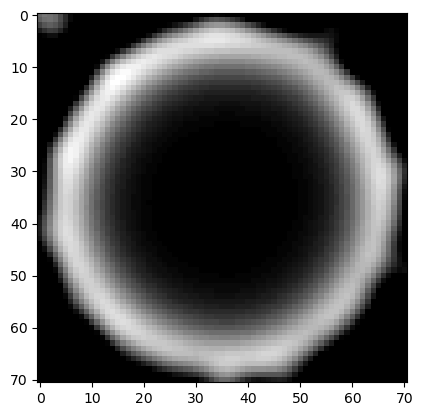

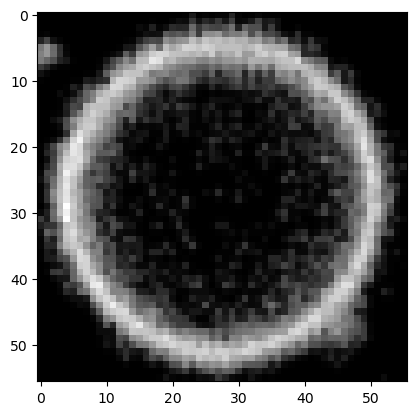

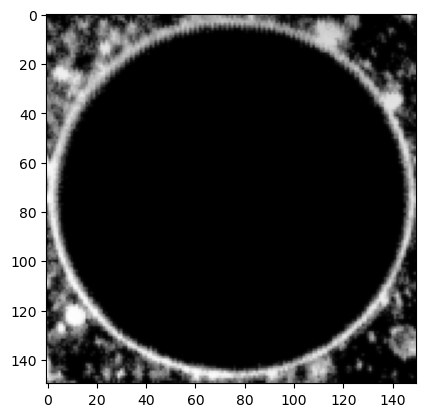

In [4]:
for template in templates:
    plt.imshow(template, cmap='gray')
    plt.show()

In [13]:
# Not doing preprocess is better for this batch of images
file_folder= '../../data/20240606/OriginalImage/June 6th 2024 Microscopy'
PlateName='Plate_20240607'
# Create the folder if it doesn't exist
folder_path = f"Results_{PlateName}"
os.makedirs(folder_path, exist_ok=True)
# Record the start time
import time
start_time = time.time()
run_batch_files_templates(file_folder, templates, PlateName, \
                min_scale=0.3, max_scale=4, intervals=100, threshold = 0.5, Preprocess=False)

# Record the end time
end_time = time.time()

# Calculate the running time
running_time = end_time - start_time

print("Script execution time:", running_time, "seconds")

443 vesicles found
WellK14_PointK14_0000_ChannelNile Red_Seq0680.ome.tiff
1 vesicles found
WellH04_PointH04_0003_ChannelNile Red_Seq0475.ome.tiff
2 vesicles found
WellF10_PointF10_0003_ChannelNile Red_Seq0291.ome.tiff
189 vesicles found
WellD15_PointD15_0003_ChannelNile Red_Seq0111.ome.tiff
91 vesicles found
WellE17_PointE17_0002_ChannelNile Red_Seq0218.ome.tiff
59 vesicles found
WellK05_PointK05_0001_ChannelNile Red_Seq0645.ome.tiff
27 vesicles found
WellH09_PointH09_0000_ChannelNile Red_Seq0452.ome.tiff
2 vesicles found
WellE14_PointE14_0002_ChannelNile Red_Seq0206.ome.tiff
137 vesicles found
WellC08_PointC08_0001_ChannelNile Red_Seq0021.ome.tiff
322 vesicles found
WellC21_PointC21_0003_ChannelNile Red_Seq0075.ome.tiff
2 vesicles found
WellI20_PointI20_0003_ChannelNile Red_Seq0551.ome.tiff
56 vesicles found
WellD13_PointD13_0001_ChannelNile Red_Seq0117.ome.tiff
254 vesicles found
WellC21_PointC21_0000_ChannelNile Red_Seq0072.ome.tiff
13 vesicles found
WellJ15_PointJ15_0002_ChannelNil

### Data construction

In [18]:
df = pd.read_csv('../../data/20240606/VesicleDetection/Results_Plate_20240607/Plate_20240607_VesiclesSummary.csv')
df

,filename,num_vesicles,area_vesicles,area_percent
0,WellK14_PointK14_0000_ChannelNile Red_Seq0680....,443,204038.588869,0.194586
1,WellH04_PointH04_0003_ChannelNile Red_Seq0475....,1,660.519855,0.000630
2,WellF10_PointF10_0003_ChannelNile Red_Seq0291....,2,2150.420171,0.002051
3,WellD15_PointD15_0003_ChannelNile Red_Seq0111....,189,77438.688115,0.073851
4,WellE17_PointE17_0002_ChannelNile Red_Seq0218....,91,33473.669724,0.031923
...,...,...,...,...
763,WellG13_PointG13_0001_ChannelNile Red_Seq0361....,164,70758.091337,0.067480
764,WellL09_PointL09_0001_ChannelNile Red_Seq0741....,70,41209.841633,0.039301
765,WellE09_PointE09_0003_ChannelNile Red_Seq0187....,370,189012.351207,0.180256
766,WellK07_PointK07_0003_ChannelNile Red_Seq0655....,0,0.000000,0.000000


In [19]:
df_sorted = df.sort_values(by='filename')

# Extract the part before the first '_' in 'filename'
df_sorted['group'] = df_sorted['filename'].str.split('_').str[0]

# Group by 'group', take median of other columns, and keep the first row
df_final = df_sorted.groupby('group').agg({
    'filename': 'first',
    'num_vesicles': 'median',
    'area_vesicles': 'median',
    'area_percent': 'median'
}).reset_index(drop=True)

# Round num_vesicles to integer
df_final['num_vesicles'] = df_final['num_vesicles'].round().astype(int)
# By default, round() uses "round half to even" (also known as "bankers' rounding") 
# Extracting positions from filename column
df_final['position'] = df_final['filename'].str.extract(r'Well([A-Z]+\d+)_')

# Dropping the original filename column
df_final = df_final[['position', 'num_vesicles', 'area_vesicles', 'area_percent']]
df_final

,position,num_vesicles,area_vesicles,area_percent
0,C03,42,14170.546363,0.013514
1,C04,60,24196.153919,0.023075
2,C05,32,18756.486239,0.017888
3,C06,3,1142.361629,0.001089
4,C07,44,18655.169876,0.017791
...,...,...,...,...
187,L11,122,64363.772190,0.061382
188,L12,45,18108.532754,0.017270
189,L13,460,159066.690033,0.151698
190,L14,434,152377.061176,0.145318


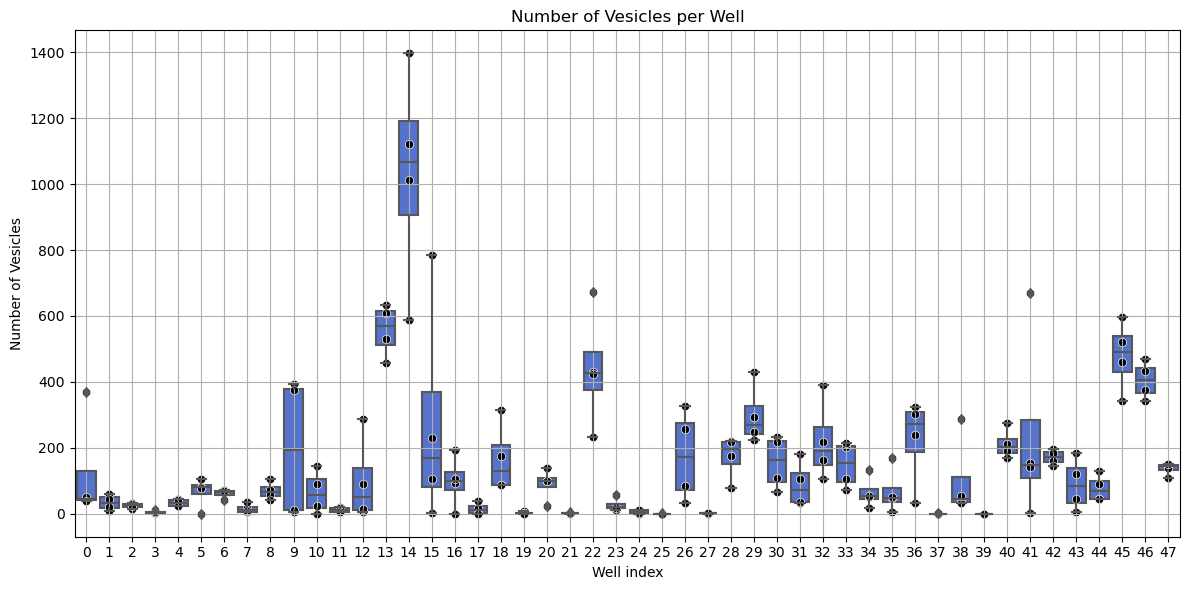

In [20]:
# Create a figure and axis
plt.figure(figsize=(12, 6))
ax = sns.boxplot(x=df_final.index % 48, y='num_vesicles', data=df_final, color='royalblue')

# Scatter plot without NaN values
sns.scatterplot(x=df_final.index % 48, y='num_vesicles', data=df_final.dropna(), color='black', ax=ax)

# Set labels and title
ax.set_xlabel('Well index')
ax.set_ylabel('Number of Vesicles')
ax.set_title('Number of Vesicles per Well')

# Show plot
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
num_rows_per_df = 48
numeric_df = df_final.select_dtypes(include=np.number)

# Calculate the median values along the rows
median_values = numeric_df.groupby(numeric_df.index % num_rows_per_df).median()

# Print the median values
median_values

,num_vesicles,area_vesicles,area_percent
0,46.0,14089.061304,0.013436
1,33.5,26374.848424,0.025153
2,27.0,18298.599110,0.017451
3,3.5,1575.901415,0.001503
4,32.5,13276.959603,0.012662
5,80.0,30555.915547,0.029140
6,66.0,27179.292493,0.025920
7,11.5,5227.217476,0.004985
8,65.0,43924.963084,0.041890
9,193.5,86737.409670,0.082719


In [22]:
dispense_df = pd.read_csv('dispense_df_GPC_20240603.csv')
dispense_df

,decanoic acid_Concentration (50 mM),decanoic acid_Concentration (10 mM),decanoic acid_Concentration (2 mM),decanoate_Concentration (50 mM),decanoate_Concentration (10 mM),decanoate_Concentration (2 mM),decylamine_Concentration (50 mM),decylamine_Concentration (10 mM),decylamine_Concentration (2 mM),decyl trimethylamine_Concentration (50 mM),decyl trimethylamine_Concentration (10 mM),decyl trimethylamine_Concentration (2 mM),decylsulfate_Concentration (50 mM),decylsulfate_Concentration (10 mM),decylsulfate_Concentration (2 mM),decanol_Concentration (15 mM),decanol_Concentration (3 mM),monocaprin_Concentration (10 mM),monocaprin_Concentration (2 mM)
0,9.3,0.0,0.0,9.1,0.0,0.0,7.4,0.0,0.0,0.0,12.9,0.0,0.0,0.0,4.9,0.0,3.1,5.2,0.0
1,8.6,0.0,0.0,4.3,0.0,0.0,8.7,0.0,0.0,0.0,12.2,0.0,0.0,11.5,0.0,4.2,0.0,0.0,17.7
2,8.8,0.0,0.0,0.0,0.0,1.4,5.3,0.0,0.0,0.0,0.0,14.5,6.8,0.0,0.0,6.5,0.0,8.8,0.0
3,7.7,0.0,0.0,0.0,7.5,0.0,0.0,11.4,0.0,8.5,0.0,0.0,0.0,11.7,0.0,0.0,17.5,0.0,5.8
4,4.5,0.0,0.0,6.8,0.0,0.0,9.5,0.0,0.0,0.0,12.3,0.0,0.0,19.0,0.0,6.1,0.0,0.0,6.3
5,7.1,0.0,0.0,0.0,12.7,0.0,0.0,16.5,0.0,4.9,0.0,0.0,0.0,15.5,0.0,5.1,0.0,4.0,0.0
6,6.0,0.0,0.0,0.0,0.0,11.1,9.1,0.0,0.0,4.3,0.0,0.0,4.1,0.0,0.0,5.3,0.0,8.9,0.0
7,8.2,0.0,0.0,0.0,18.4,0.0,5.2,0.0,0.0,6.0,0.0,0.0,0.0,5.4,0.0,0.0,2.0,0.0,17.5
8,5.7,0.0,0.0,0.0,0.0,18.5,0.0,13.1,0.0,0.0,11.3,0.0,6.3,0.0,0.0,0.0,16.7,0.0,0.7
9,0.0,19.9,0.0,0.0,19.5,0.0,0.0,0.0,0.2,7.8,0.0,0.0,0.0,16.3,0.0,6.6,0.0,4.8,0.0


In [23]:
# List of solutes you want to extract
solutes = ['decanoic acid', 'decanoate', 'decylamine', 'decyl trimethylamine', 'decylsulfate', 'decanol', 'monocaprin']

# Create a new DataFrame to store the results
result_df = pd.DataFrame()

for solute in solutes:
    solute_columns = [col for col in dispense_df.columns if solute in col]
    concentrations = [float(re.search(r'\d+', col).group()) for col in solute_columns]
    total_con_column = solute + '_Concentration (mM)'
    result_df[total_con_column] = (dispense_df[solute_columns] * concentrations).sum(axis=1)

# Display the new DataFrame with the added columns
# Divide all column values by 200
result_df = result_df.div(200)
result_df

,decanoic acid_Concentration (mM),decanoate_Concentration (mM),decylamine_Concentration (mM),decyl trimethylamine_Concentration (mM),decylsulfate_Concentration (mM),decanol_Concentration (mM),monocaprin_Concentration (mM)
0,2.325,2.275,1.850,0.645,0.049,0.0465,0.260
1,2.150,1.075,2.175,0.610,0.575,0.3150,0.177
2,2.200,0.014,1.325,0.145,1.700,0.4875,0.440
3,1.925,0.375,0.570,2.125,0.585,0.2625,0.058
4,1.125,1.700,2.375,0.615,0.950,0.4575,0.063
5,1.775,0.635,0.825,1.225,0.775,0.3825,0.200
6,1.500,0.111,2.275,1.075,1.025,0.3975,0.445
7,2.050,0.920,1.300,1.500,0.270,0.0300,0.175
8,1.425,0.185,0.655,0.565,1.575,0.2505,0.007
9,0.995,0.975,0.002,1.950,0.815,0.4950,0.240


In [24]:
df_combine = pd.concat([result_df, median_values], axis=1)
df_combine

,decanoic acid_Concentration (mM),decanoate_Concentration (mM),decylamine_Concentration (mM),decyl trimethylamine_Concentration (mM),decylsulfate_Concentration (mM),decanol_Concentration (mM),monocaprin_Concentration (mM),num_vesicles,area_vesicles,area_percent
0,2.325,2.275,1.850,0.645,0.049,0.0465,0.260,46.0,14089.061304,0.013436
1,2.150,1.075,2.175,0.610,0.575,0.3150,0.177,33.5,26374.848424,0.025153
2,2.200,0.014,1.325,0.145,1.700,0.4875,0.440,27.0,18298.599110,0.017451
3,1.925,0.375,0.570,2.125,0.585,0.2625,0.058,3.5,1575.901415,0.001503
4,1.125,1.700,2.375,0.615,0.950,0.4575,0.063,32.5,13276.959603,0.012662
5,1.775,0.635,0.825,1.225,0.775,0.3825,0.200,80.0,30555.915547,0.029140
6,1.500,0.111,2.275,1.075,1.025,0.3975,0.445,66.0,27179.292493,0.025920
7,2.050,0.920,1.300,1.500,0.270,0.0300,0.175,11.5,5227.217476,0.004985
8,1.425,0.185,0.655,0.565,1.575,0.2505,0.007,65.0,43924.963084,0.041890
9,0.995,0.975,0.002,1.950,0.815,0.4950,0.240,193.5,86737.409670,0.082719


In [25]:
df_combine.to_csv('df_combine_20240607.csv', index=False)